In [1]:
import omnipath as op
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pySankey import sankey as sn
import mellon as ml
import networkx as nx
from matplotlib.pyplot import figure
import glob
import netrd
import itertools
import random
import pickle
random.seed(42)

c:\Users\melis\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
path = glob.glob("processed_data/00-hot_one_encode_disease_genes/hot-encoded-diseases_*.csv")

comparison = pd.DataFrame(np.zeros(shape=(13,5)), index = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7], columns = ['number of LRs', 'number of diseases', '% ligands', '% receptors', '% genes in major network'])
top = pd.read_csv('/Users/melis/Documents/GitHub/LR_project/raw_data/OpenTargets_01-04-2025/PD_OT-MONDO_0005180-associated-targets-01_04_2025-v25_03.tsv', sep = '\t', index_col = 0)
top = top[top['gwasCredibleSets']!='No data']
top['gwasCredibleSets'] = top['gwasCredibleSets'].astype(float)
top = list(top[top['gwasCredibleSets']>0.4].index)

for res in range(0,13):
    db = op.interactions.import_intercell_network(transmitter_params = {"categories":"ligand"}, receiver_params = {"categories": "receptor"})
    print(np.shape(db))
    db = db[np.logical_not(db['genesymbol_intercell_source'].str.startswith('HLA'))]
    db = db[np.logical_not(db['genesymbol_intercell_target'].str.startswith('HLA'))]
    db = db[~db['genesymbol_intercell_target'].astype(str).str.startswith('COMPLEX')]
    db = db[~db['genesymbol_intercell_source'].astype(str).str.startswith('COMPLEX')]
    print(np.shape(db))
    tgts_all = pd.read_csv(path[res])
    tgts_all['gene']=tgts_all['genes']
    tgts = tgts_all.drop(columns=['genes']).set_index(['gene'])

    source, percSrc, targets, percTgt, sum = ml.lr.find_hits(tgts, db)
    
    comparison['number of diseases'].iloc[res] = len(tgts.columns)
    comparison['% ligands'].iloc[res] = percSrc
    comparison['% receptors'].iloc[res] = percTgt

    LRs = db[['genesymbol_intercell_source','genesymbol_intercell_target']][(db['genesymbol_intercell_source'].isin(list(sum.gene))) | (db['genesymbol_intercell_target'].isin(list(sum.gene)))]
    unique_genes = np.unique(list(LRs['genesymbol_intercell_source'])+list(LRs['genesymbol_intercell_target']))

    comparison['number of LRs'].iloc[res] = len(unique_genes)

    # Adjacency matrix with entire network across all diseases
    adj_LRs = pd.DataFrame(np.zeros(shape=(len(unique_genes), len(unique_genes))), index = unique_genes, columns = unique_genes)

    for n in range (0, np.shape(LRs)[0]):
        adj_LRs.iloc[adj_LRs.index.get_loc(LRs.iloc[n]['genesymbol_intercell_source']), adj_LRs.columns.get_loc(LRs.iloc[n]['genesymbol_intercell_target'])] += 1

    #Number of cell-cell interactions ligands of interest are involved in
    print(adj_LRs.sum(axis = 0).sort_values(ascending=False)[adj_LRs.sum(axis = 0).sort_values(ascending=False).index.isin(list(tgts.index))])

    #Number of cell-cell interactions receptors of interest are involved in
    adj_LRs.sum(axis = 1).sort_values(ascending=False)[adj_LRs.sum(axis = 1).sort_values(ascending=False).index.isin(list(tgts.index))]

    # Overview of LR network and calculating rank of importance with PageRank

    H = nx.from_pandas_adjacency(adj_LRs)
    # save graph object to file
    pickle.dump(H, open('processed_data/03-LR_network_visualisation/03a_genetic_association_test/network_file_%s.pickle' % list(comparison.index)[res], 'wb'))

    plt.figure(figsize=(30,30), dpi = 300)
    sm = nx.draw_networkx(H, with_labels=False, node_size = 50)
    plt.close()
    
    PDgenes = ['SNCA', 'PRKN', 'PARK7', 'LRRK2', 'PINK1', 'POLG', 'ATP13A2', 'FBXO7', 'GBA', 'PLA2G6', 'VPS35', 'DNAJC6', 'SYNJ1', 'VPS13C']
    PDcolours = []
    for i in H.nodes:
        if i in PDgenes:
            PDcolours.append('deeppink')
        else:
            PDcolours.append('paleturquoise')
    len(PDcolours)
    plt.figure(figsize=(25,25), dpi = 300)
    nx.draw_networkx(H, node_color=PDcolours, with_labels=False, node_size = 50)
    plt.savefig("plots/03-LR_network_visualisation/louvain_clusters_network_PDgenes_%s.png" % list(comparison.index)[res], dpi = 300)
    plt.close()
    
    subnodelist = ['SNCA',  'PINK1', 'POLG', 'ATP13A2', 'FBXO7', 'GBA', 'PLA2G6', 'VPS35', 'DNAJC6', 'SYNJ1', 'VPS13C']
    intersect = list(set(H.nodes) & set(subnodelist))
    labels = {k:k for k in intersect} 
    plt.figure(figsize=(25,25), dpi = 300)
    pos = nx.spring_layout(H)
    nx.draw_networkx_nodes(H, pos, node_color=PDcolours, node_size = 50)
    nx.draw_networkx_edges(H, pos)
    # draw labels only for the nodes in subnodelist
    nx.draw_networkx_labels(H, pos, labels=labels)
    plt.savefig("plots/03-LR_network_visualisation/louvain_clusters_network_PDgenes_withlabels_%s.png" % list(comparison.index)[res], dpi = 300)
    plt.close()

    PDcolours = []
    for i in H.nodes:
        if i in list(top):
            PDcolours.append('deeppink')
        else:
            PDcolours.append('paleturquoise')
    len(PDcolours)
    plt.figure(figsize=(25,25), dpi = 300)
    nx.draw_networkx(H, node_color=PDcolours, with_labels=False, node_size = 50)
    plt.savefig("plots/03-LR_network_visualisation/louvain_clusters_network_PD04thr_%s.png" % list(comparison.index)[res], dpi = 300)
    plt.close()
    
    intersect = list(set(H.nodes) & set(list(top)))
    labels = {k:k for k in intersect} 
    plt.figure(figsize=(25,25), dpi = 300)
    pos = nx.spring_layout(H)
    nx.draw_networkx_nodes(H, pos, node_color=PDcolours, node_size = 50)
    nx.draw_networkx_edges(H, pos, edge_color='slategrey')
    # draw labels only for the nodes in subnodelist
    nx.draw_networkx_labels(H, pos, labels=labels)
    plt.savefig("plots/03-LR_network_visualisation/louvain_clusters_network_PD04thr_withlabels_%s.png" % list(comparison.index)[res], dpi = 300)
    plt.close()
    
    comms = ml.network.louvain_communities(H, seed = 123, resolution = 0.01)

    colours = []
    for i in H.nodes:
        for m in range(0,len(comms)):
            if i in comms[m]:
                colours.append(m)
    len(colours)

    #from matplotlib.pyplot import figure
    #figure(figsize=(15, 15), dpi=80)

    plt.figure(figsize=(30,30), dpi = 300)
    nx.draw_networkx(H, node_color=colours, vmin=min(colours), vmax=max(colours), cmap=plt.get_cmap("Spectral"), with_labels=False, node_size = 50)
    plt.savefig("plots/03-LR_network_visualisation/louvain_clusters_network_%s.png" % list(comparison.index)[res], dpi = 300)
    plt.close()

    for l in range(0,len(comms)):
        this = len(comms[l])
        
        if (l == 0):
            longest = this
            cluster = comms[l]
        elif (this > longest):
            longest = this
            cluster = comms[l]
        
    comparison['% genes in major network'].iloc[res] = longest/len(H)
    print(longest/len(H))
    if (res == 0):
        major_nt = []
        major_nt.append(list(cluster))
        major_H = H.subgraph(cluster)
    else:
        major_nt.append(list(cluster))
    pd.DataFrame(list(cluster)).to_csv("processed_data/03-LR_network_visualisation/louvain_largest_cluster_%s.csv" % list(comparison.index)[res])
    
    counts_major = pd.DataFrame(pd.DataFrame(list(itertools.chain.from_iterable(major_nt))).value_counts())
    comparison.to_csv('processed_data/03-LR_network_visualisation/comparison_parameters_across_thresholds.csv')


(9708, 45)
(8345, 45)
MAPK3    82.0
MAPK1    75.0
STAT3    66.0
PLCG1    54.0
CXCR4    51.0
         ... 
EFNA5     0.0
NPNT      0.0
ETV5      0.0
NPPB      0.0
NPVF      0.0
Length: 332, dtype: float64
0.9469453376205788
(9708, 45)
(8345, 45)
MAPK3    82.0
STAT3    66.0
PLCG1    54.0
CXCR4    51.0
CCR3     46.0
         ... 
EFNA5     0.0
ETV5      0.0
NPNT      0.0
NPPB      0.0
NPVF      0.0
Length: 311, dtype: float64
0.9487603305785124
(9708, 45)
(8345, 45)
MAPK3    82.0
STAT3    66.0
PLCG1    54.0
CXCR4    51.0
CCR1     46.0
         ... 
EFNA5     0.0
NMB       0.0
ETV5      0.0
NPVF      0.0
NPNT      0.0
Length: 295, dtype: float64
0.9506688963210702
(9708, 45)
(8345, 45)
MAPK3     82.0
STAT3     66.0
CXCR4     51.0
CCR1      46.0
IGF1R     44.0
          ... 
EFNA5      0.0
NLGN4X     0.0
NMB        0.0
ETV5       0.0
NPNT       0.0
Length: 278, dtype: float64
0.950210970464135
(9708, 45)
(8345, 45)
MAPK3     82.0
STAT3     66.0
CXCR4     51.0
CCR1      46.0
CXCR6     44.0
 

AATK
ABCB1
ABL1
ACE
ACHE
ACKR2
ACKR3
ACTR2
ACVR1
ACVR1B
ACVR1C
ACVR2A
ACVR2B
ACVRL1
ADA
ADAM15
ADAMTS16
ADAMTS4
ADCY2
ADCYAP1
ADCYAP1R1
ADGRA2
ADGRV1
ADIPOQ
ADM
ADM2
ADRA2A
ADRB2
ADRB3
AFDN
AGT
AGTR1
AKT3
ALCAM
ALK
ALKAL2
ALOX12B
ALPK1
ALPK3
AMH
AMHR2
ANGPT1
ANGPT2
ANGPTL1
ANGPTL2
ANGPTL6
ANGPTL7
ANOS1
ANP32B
ANXA1
APLP1
APOA1
APOA2
APOA4
APOB
APOC2
APOC3
APOC4
APOE
APOO
APP
AQP2
AR
AREG
ARF6
ARPC5
ARRB2
ARTN
ASGR1
ATP2A2
ATP2B1
AVP
AXL
BAMBI
BCAM
BCL2
BCL2L1
BCL6
BCR
BDNF
BIRC2
BLK
BMP1
BMP10
BMP15
BMP2
BMP3
BMP4
BMP5
BMP6
BMP7
BMP8A
BMP8B
BMPR1A
BMPR1B
BMPR2
BMX
BOC
BSG
BST2
BTC
BTK
BTN1A1
BTN3A2
BTNL9
C1QL1
C1QTNF4
C3
C4B_2
CA1
CALCA
CALCB
CALCR
CALCRL
CALML3
CALR
CAMK2D
CASP3
CASP6
CASP8
CCK
CCL1
CCL11
CCL13
CCL14
CCL15
CCL16
CCL17
CCL18
CCL19
CCL2
CCL20
CCL21
CCL22
CCL23
CCL24
CCL25
CCL26
CCL27
CCL28
CCL3
CCL3L1
CCL4
CCL4L1
CCL5
CCL7
CCL8
CCN1
CCN2
CCN3
CCR1
CCR10
CCR3
CCR5
CCRL2
CD109
CD14
CD163
CD19
CD1D
CD2
CD209
CD226
CD244
CD247
CD27
CD28
CD300LB
CD300LF
CD33
CD36
CD38
CD3E
C

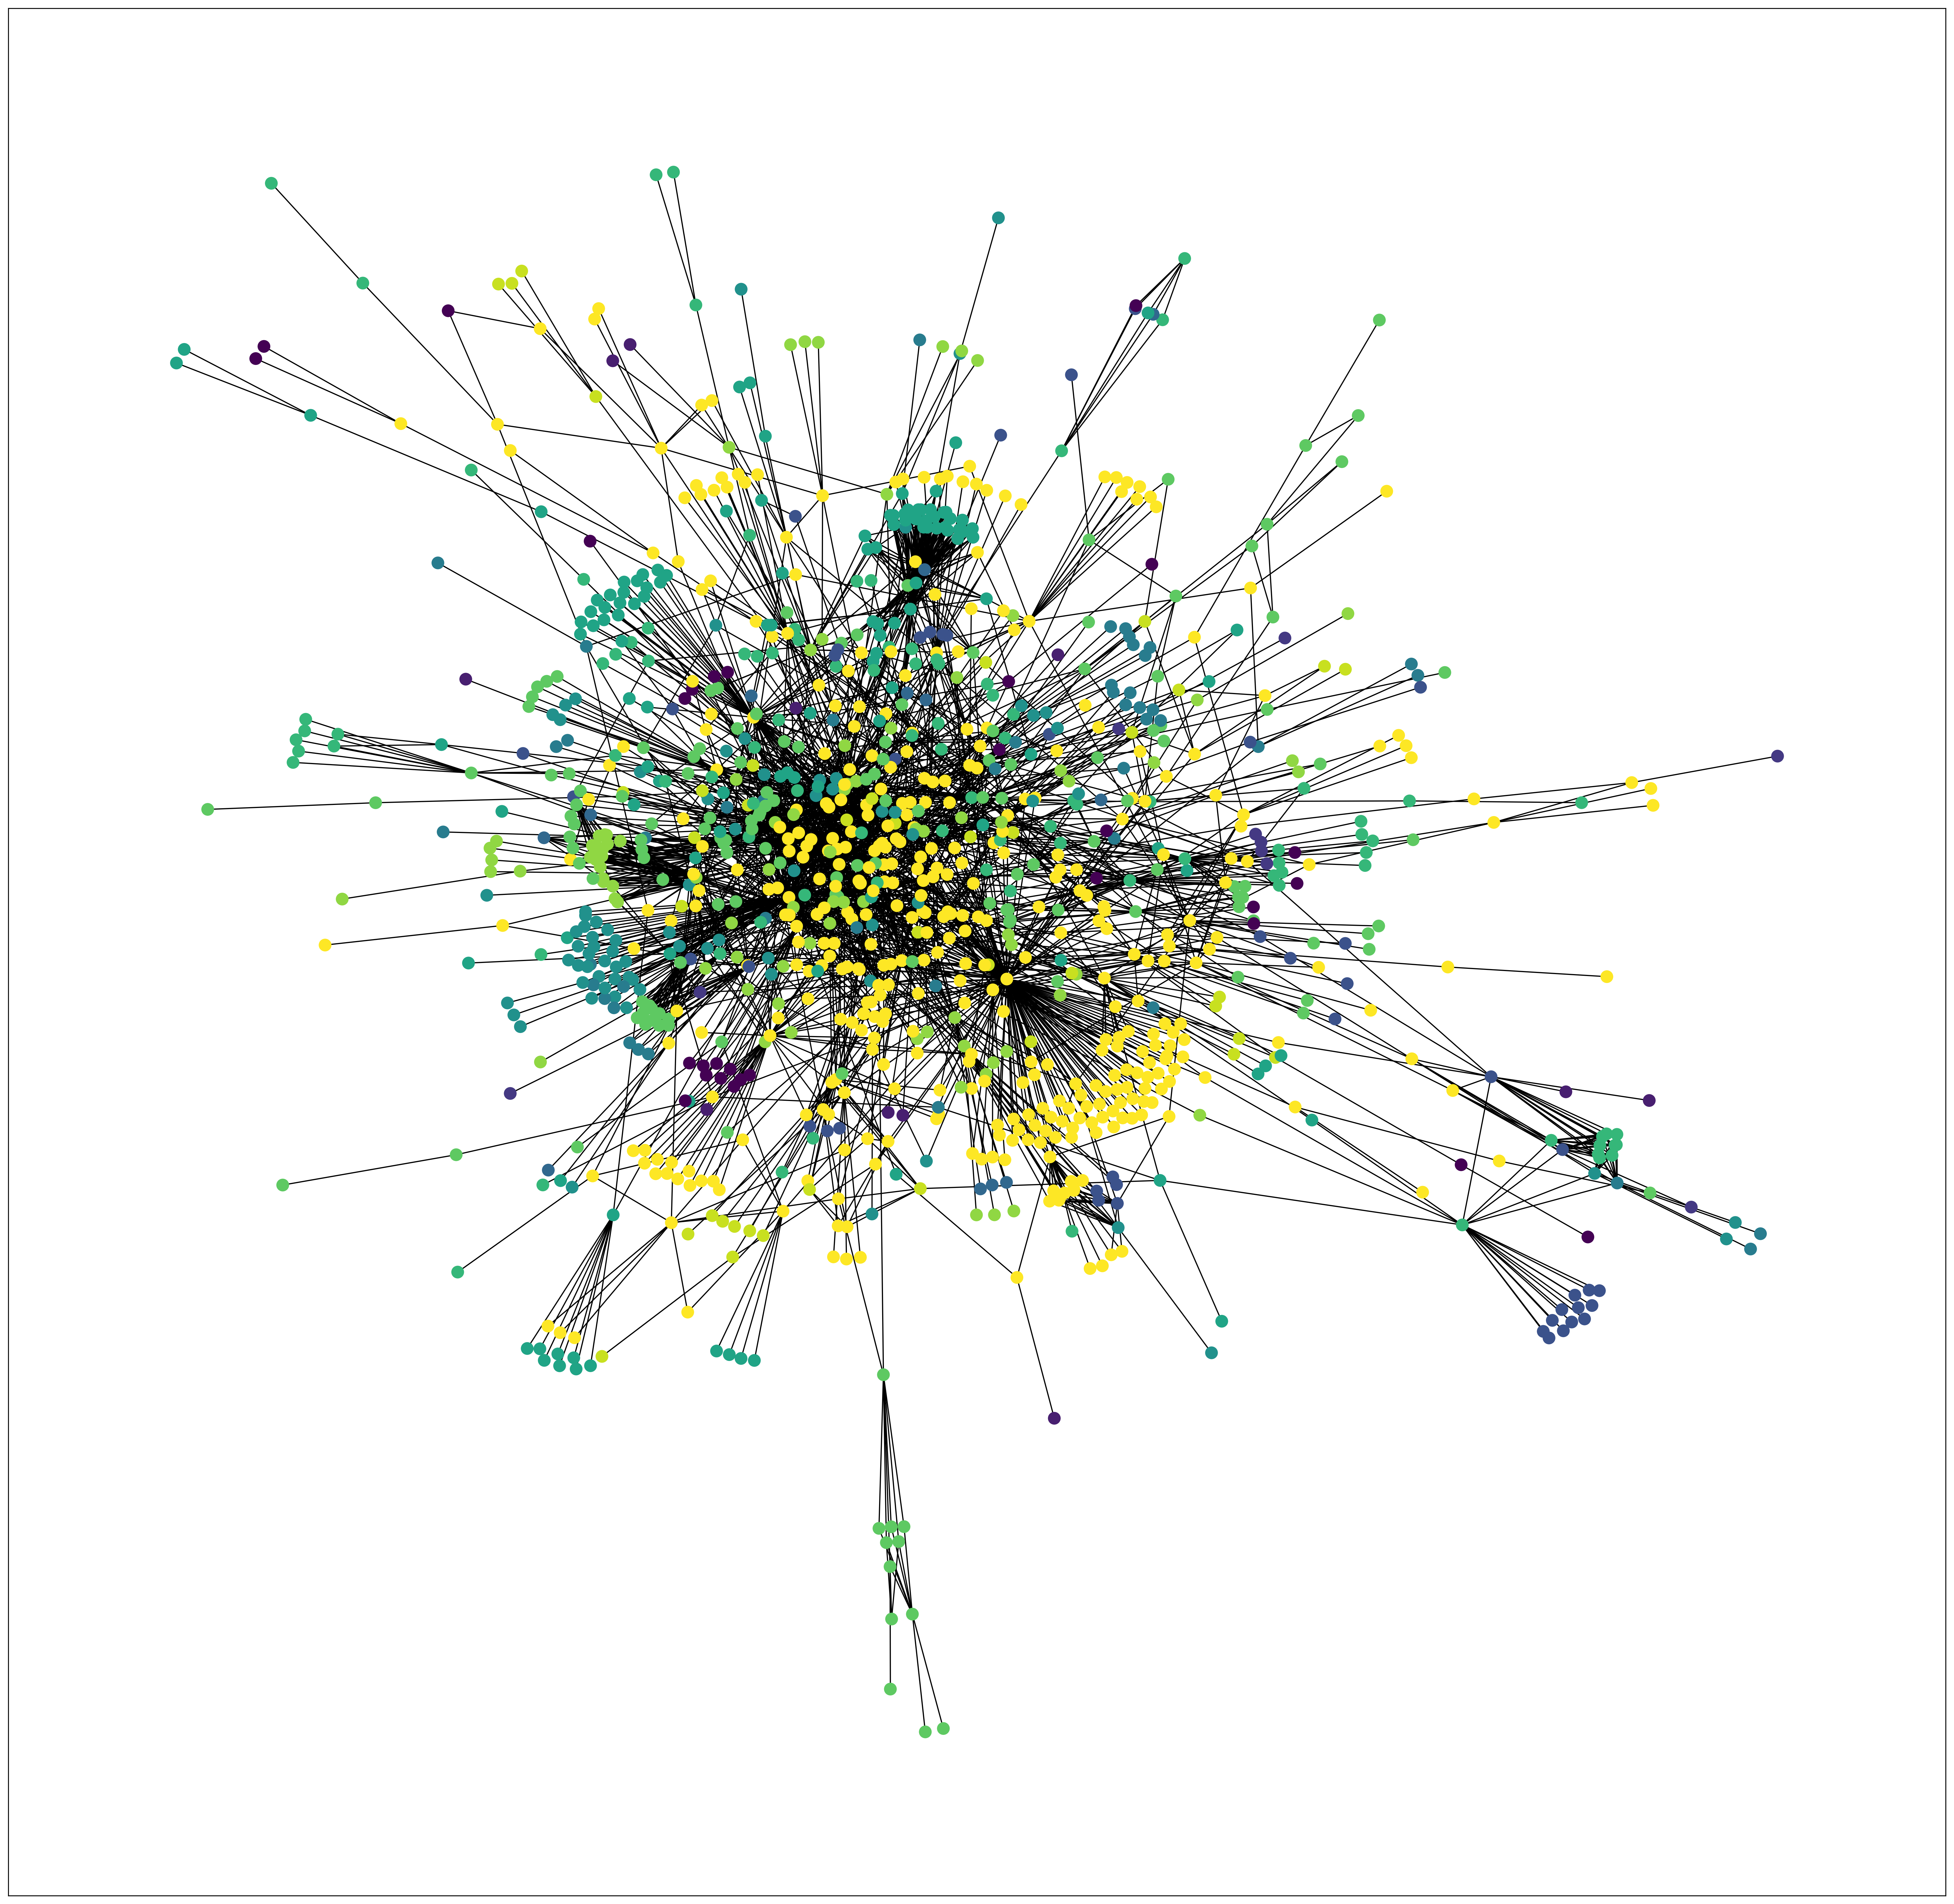

In [7]:
colours = []
for i in major_H.nodes:
    print(i)
    if i in list(itertools.chain.from_iterable(counts_major.index)):
        colours.append(int(counts_major.loc[i][0]))
    else:
        colours.append(1)

plt.figure(figsize=(30,30), dpi = 300)
nx.draw_networkx(major_H, node_color=colours, vmin=min(colours), vmax=max(colours), cmap=plt.get_cmap("viridis"), with_labels=False, node_size = 100)
plt.savefig("plots/03-LR_network_visualisation/major_01_cluster_occurances.png", dpi = 150)
plt.show()

In [8]:
comparison.to_csv('processed_data/03-LR_network_visualisation/comparison_across_thresholds_values.csv')

In [15]:
comparison

number of LRs  number of diseases  % ligands  % receptors  \
0.10         1244.0                17.0   4.549114     9.742351   
0.15         1210.0                17.0   4.895739    10.199456   
0.20         1196.0                16.0   5.112782    10.726817   
0.25         1185.0                15.0   5.341410    11.123348   
0.30         1127.0                14.0   5.031056    11.490683   
0.35         1104.0                14.0   5.303559    11.863224   
0.40         1049.0                14.0   5.271565    11.821086   
0.45          970.0                14.0   5.708849    12.559467   
0.50          845.0                14.0   6.287070    12.692764   
0.55          752.0                13.0   6.552262    13.416537   
0.60          617.0                 9.0   6.756757    14.414414   
0.65          520.0                 9.0   6.896552    14.655172   
0.70          474.0                 9.0   7.335907    16.602317   

      % genes in major network  
0.10                  0.946945  
0.15                  0.948760  
0.20                  0.950669  
0.25                  0.950211  
0.30                  0.958296  
0.35                  0.967391  
0.40                  0.973308  
0.45                  0.971134  
0.50                  0.964497  
0.55                  0.952128  
0.60                  0.912480  
0.65                  0.913462  
0.70                  0.917722

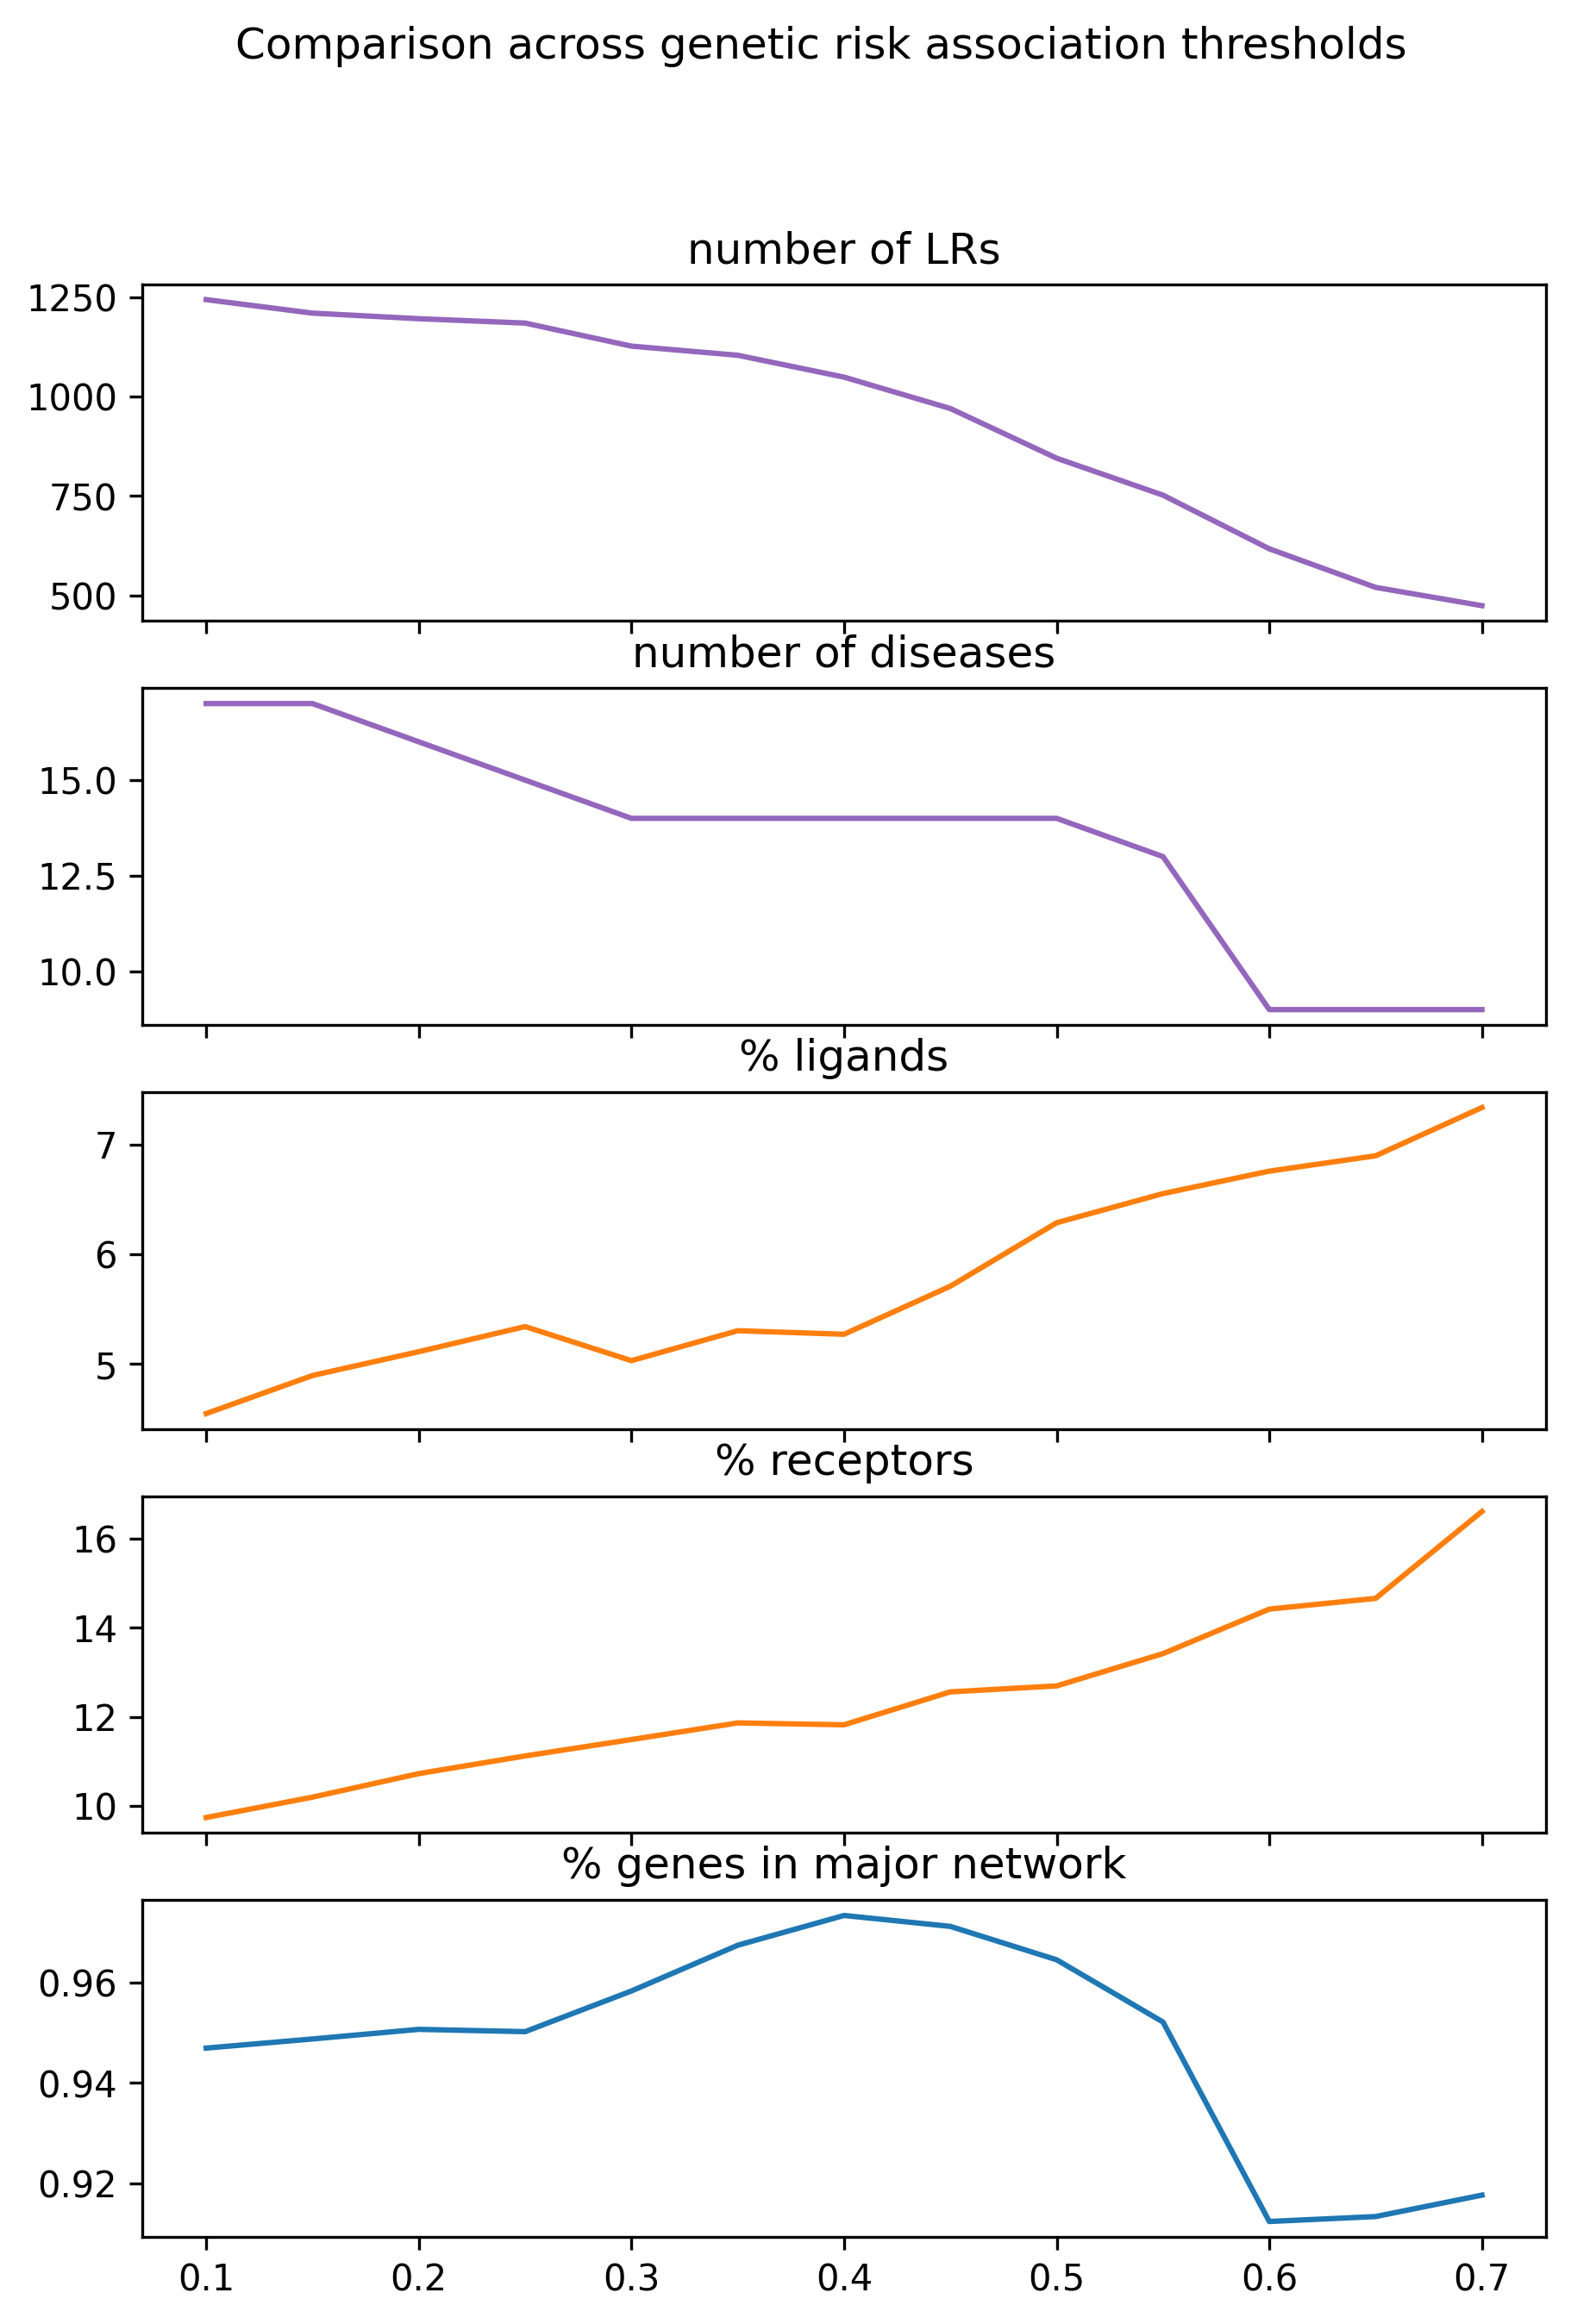

In [9]:
x = list(comparison.index)

fig, axs = plt.subplots(5, sharex=True, sharey=False, figsize=(7,10), dpi = 300)
fig.suptitle('Comparison across genetic risk association thresholds')
axs[0].plot(x, comparison['number of LRs'], 'tab:purple')
axs[0].set_title('number of LRs')
axs[1].plot(x, comparison['number of diseases'], 'tab:purple')
axs[1].set_title('number of diseases')
axs[2].plot(x, comparison['% ligands'], 'tab:orange')
axs[2].set_title('% ligands')
axs[3].plot(x, comparison['% receptors'], 'tab:orange')
axs[3].set_title('% receptors')
axs[4].plot(x, comparison['% genes in major network'], 'tab:blue')
axs[4].set_title('% genes in major network')
plt.savefig("plots/03-LR_network_visualisation/statistics_genetic_association_trajectory.png", dpi =300)

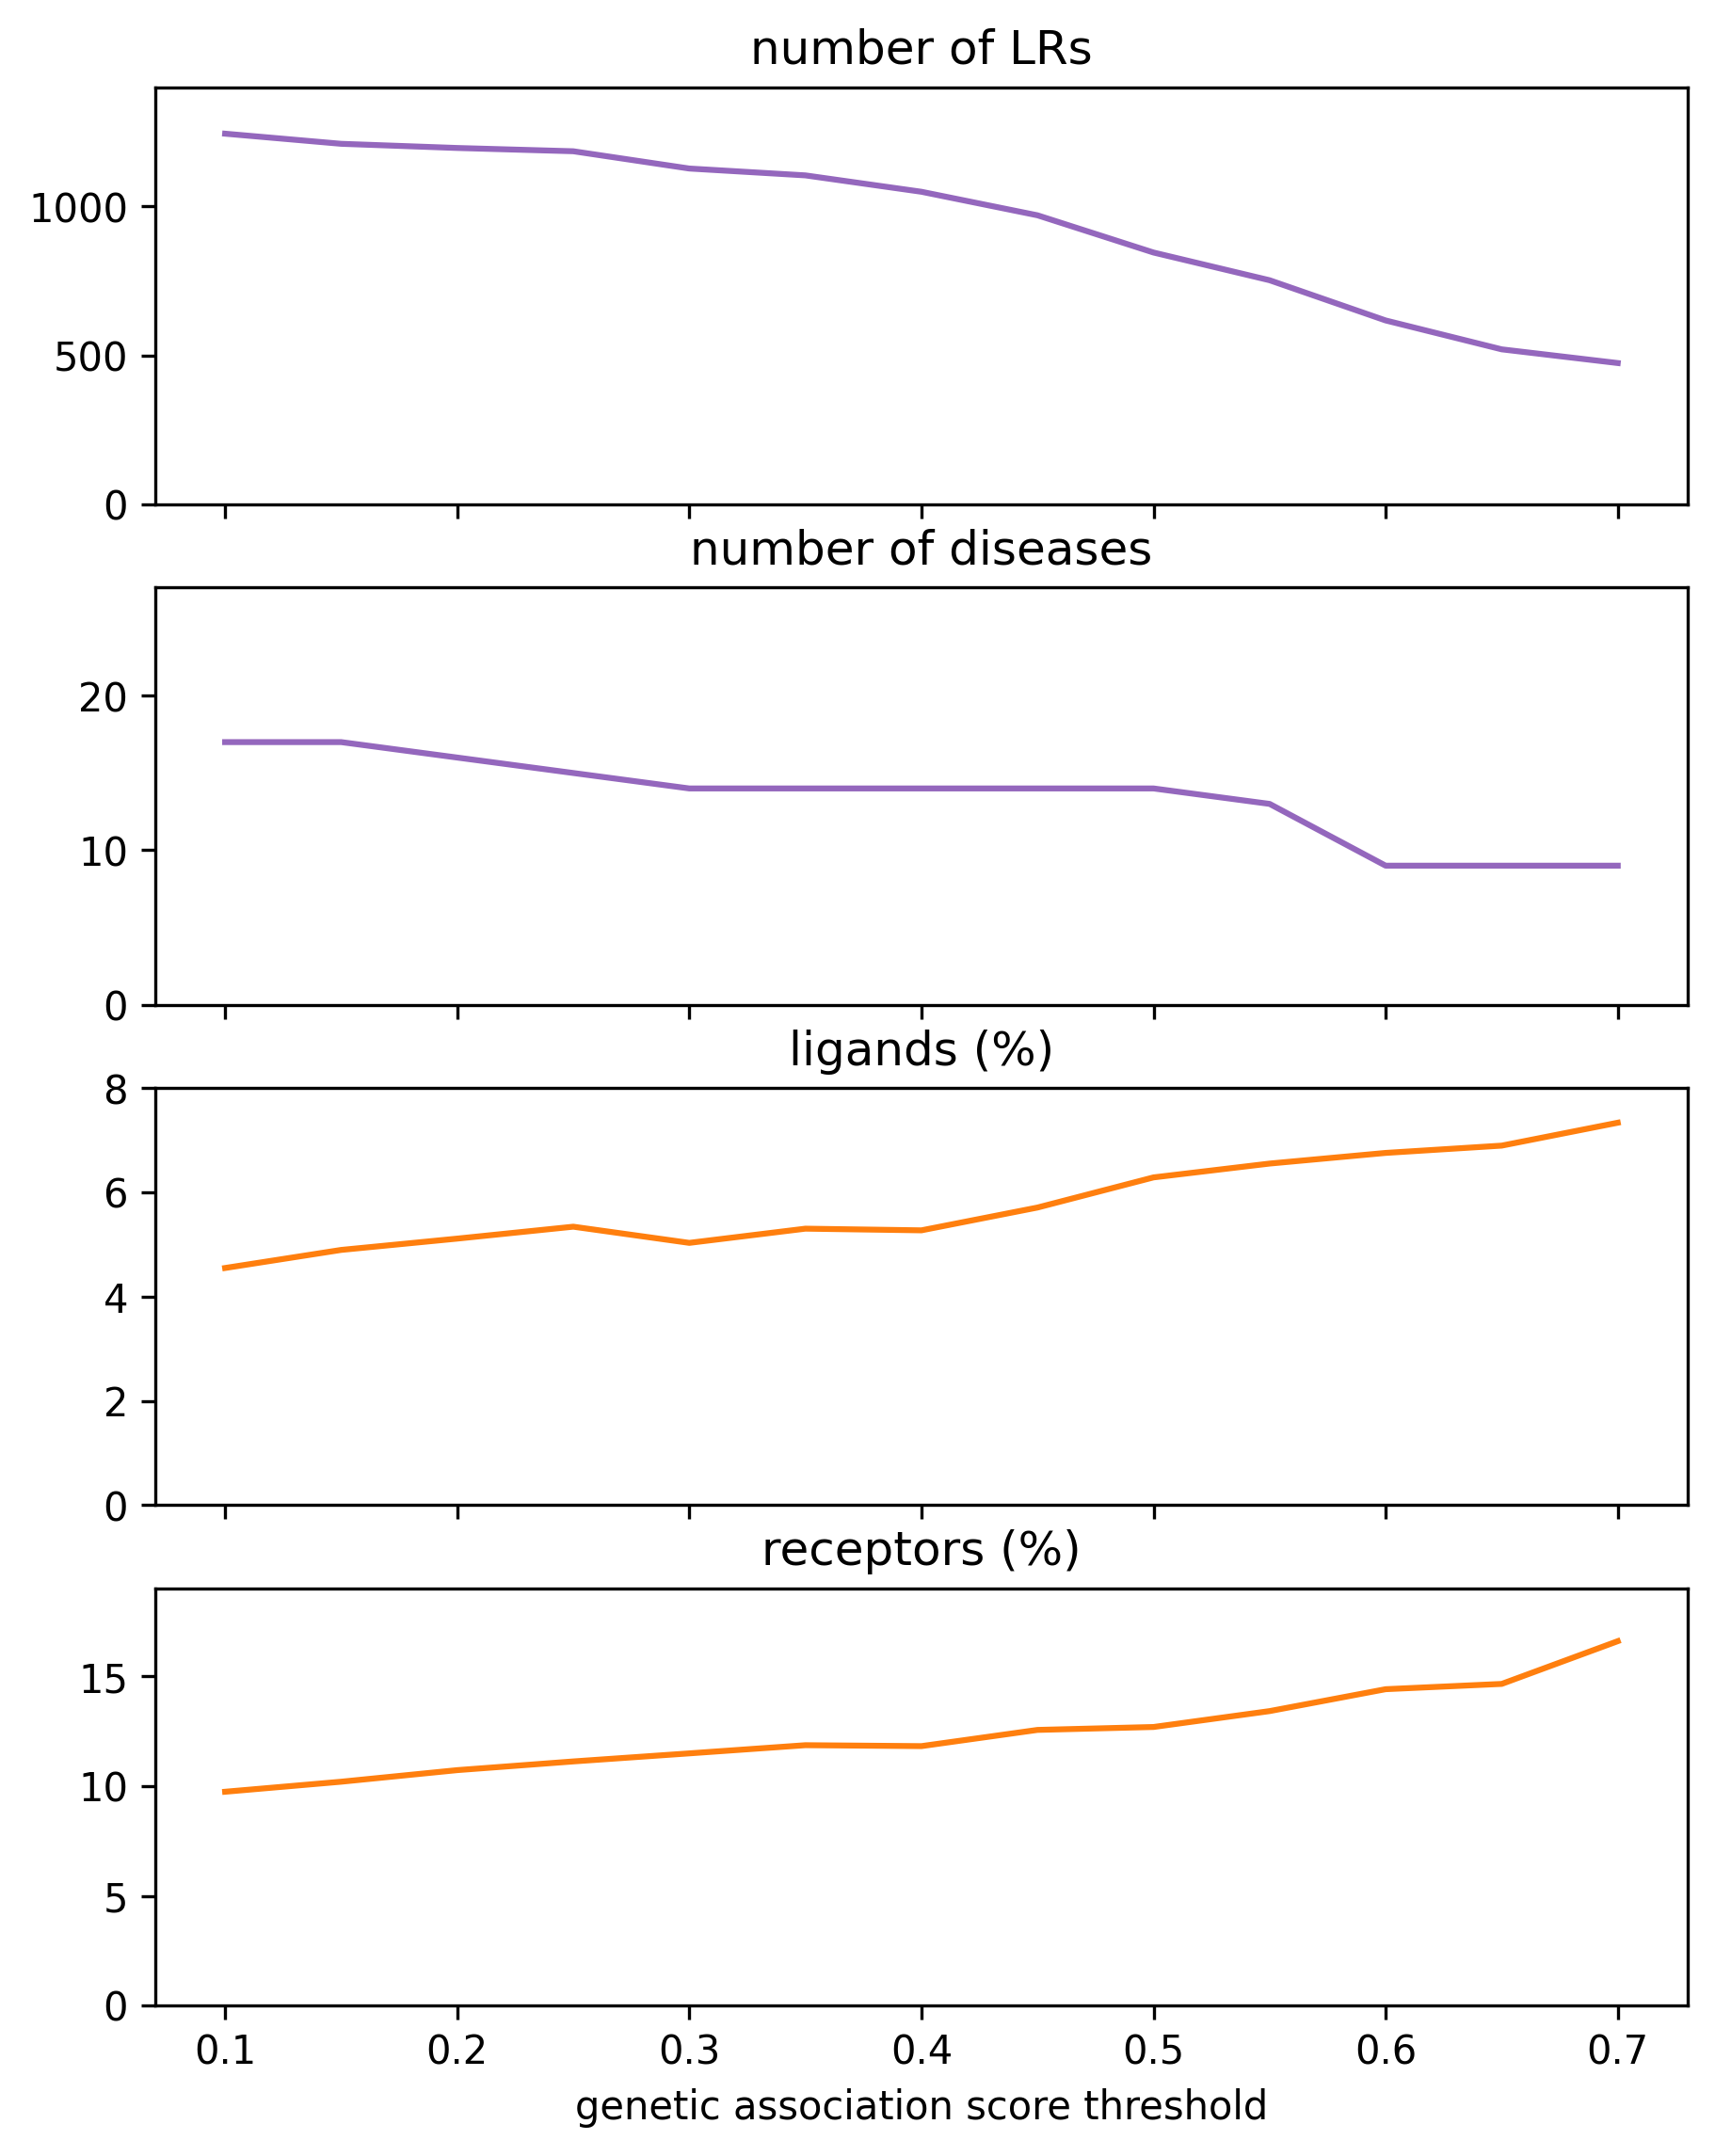

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

comparison = pd.read_csv('processed_data/03-LR_network_visualisation/comparison_across_thresholds_values.csv', index_col = 0)
x = list(comparison.index)

fig, axs = plt.subplots(4, sharex=True, sharey=False, figsize=(7,9), dpi = 300)
#fig.suptitle('Comparison across genetic risk association thresholds')
axs[0].plot(x, comparison['number of LRs'], 'tab:purple')
axs[0].set_title('number of LRs')
axs[0].set_ylim([0, 1400])
axs[1].plot(x, comparison['number of diseases'], 'tab:purple')
axs[1].set_title('number of diseases')
axs[1].set_ylim([0, 27])
axs[2].plot(x, comparison['% ligands'], 'tab:orange')
axs[2].set_title('ligands (%)')
axs[2].set_ylim([0, 8])
axs[3].plot(x, comparison['% receptors'], 'tab:orange')
axs[3].set_title('receptors (%)')
axs[3].set_ylim([0, 19])
plt.xlabel('genetic association score threshold')
plt.savefig("plots/03-LR_network_visualisation/statistics_genetic_association_trajectory_LRs.png", dpi =300)
plt.show()

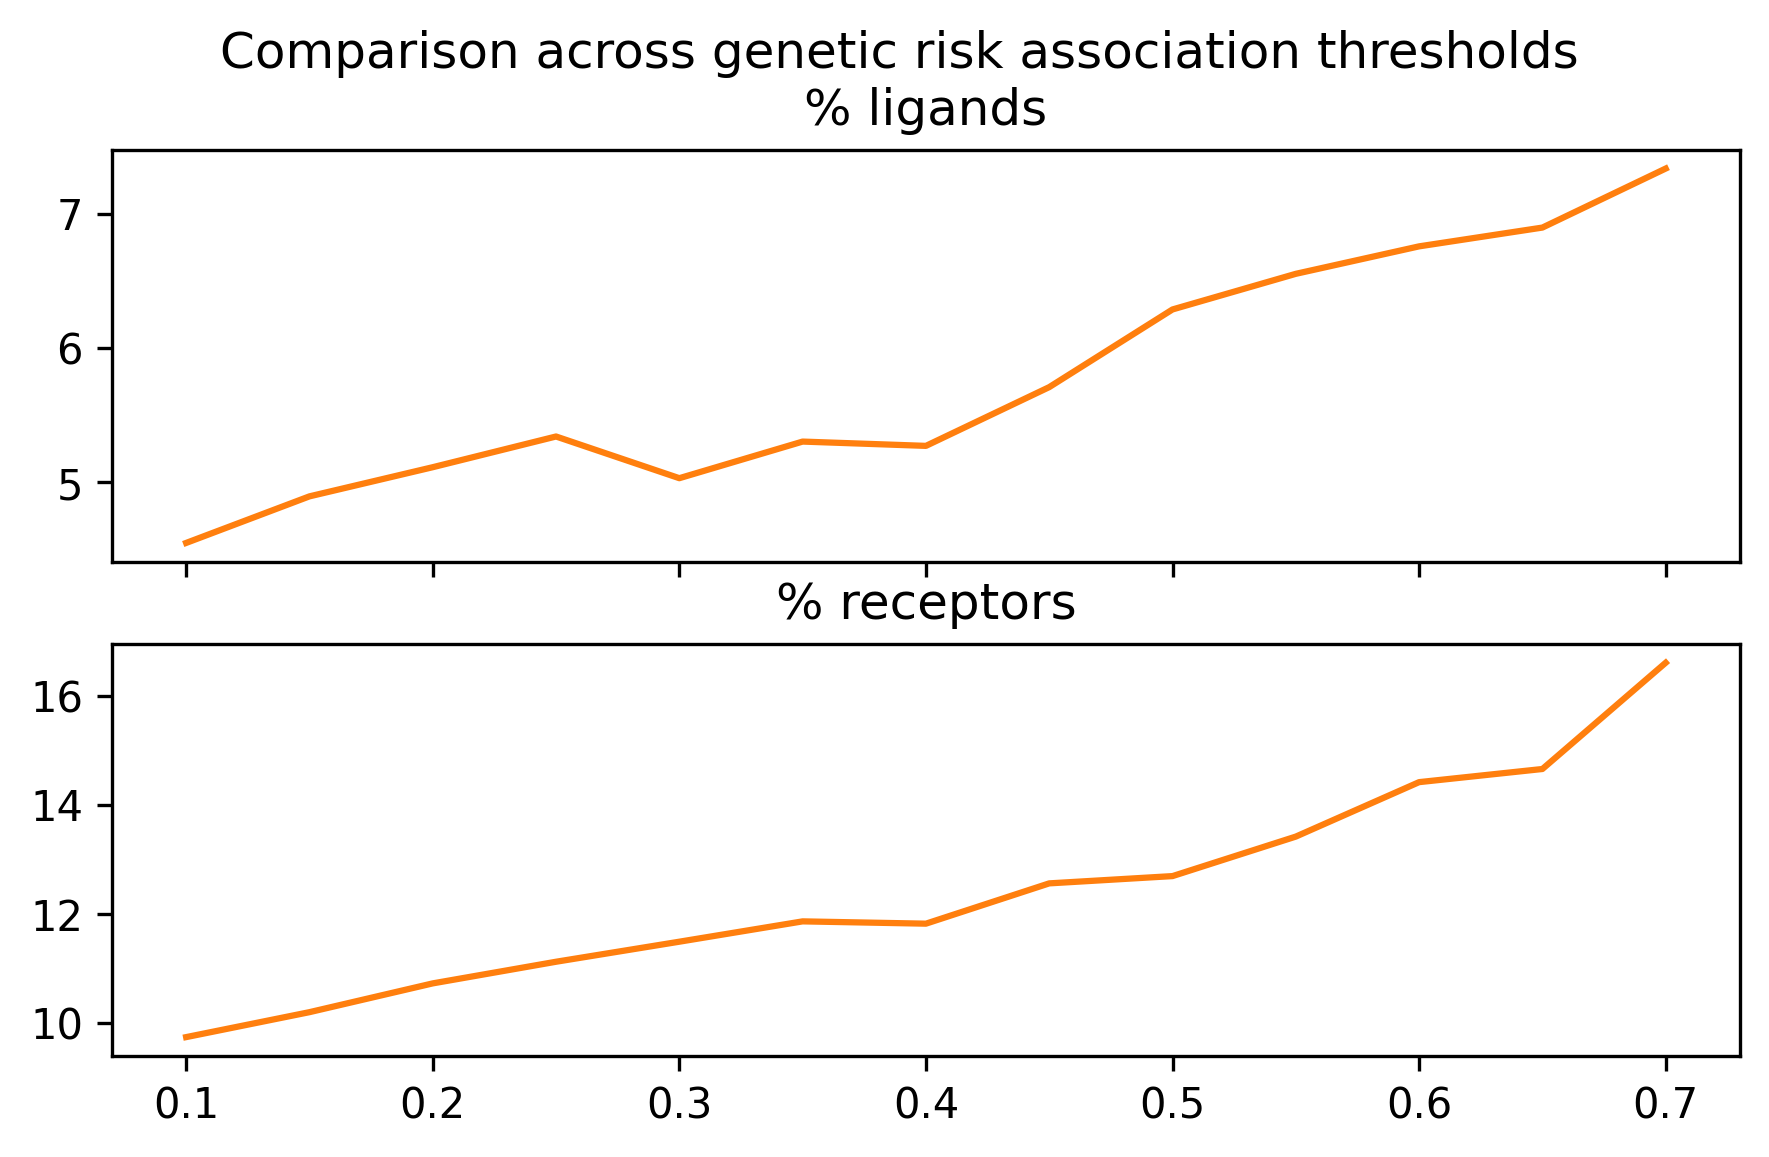

In [14]:
x = list(comparison.index)

fig, axs = plt.subplots(2, sharex=True, sharey=False, figsize=(7,4), dpi = 300)
fig.suptitle('Comparison across genetic risk association thresholds')

axs[0].plot(x, comparison['% ligands'], 'tab:orange')
axs[0].set_title('% ligands')
axs[1].plot(x, comparison['% receptors'], 'tab:orange')
axs[1].set_title('% receptors')

plt.savefig("plots/03-LR_network_visualisation/statistics_genetic_association_trajectory_LRs.png", dpi =300)

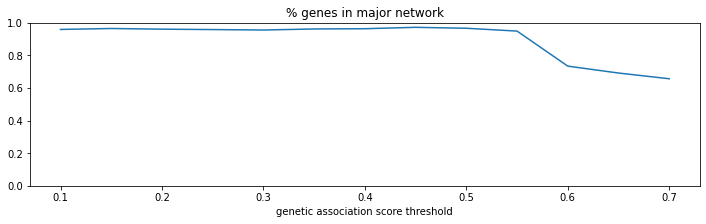

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

comparison = pd.read_csv('processed_data/03-LR_network_visualisation/comparison_across_thresholds_values.csv', index_col = 0)
x = list(comparison.index)
plt.figure(figsize=(12,3))
plt.plot(x, comparison['% genes in major network'], 'tab:blue')
plt.title('genes in major network (%)')
plt.ylim([0, 1])
plt.xlabel('genetic association score threshold')
plt.savefig("plots/03-LR_network_visualisation/statistics_genetic_association_trajectory_network.png", dpi =300, bbox_inches='tight')
plt.show()